# ML Applications to Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

## Logistic Regression

In this study, we implemented Logistic Regression as a classification model to predict Autism Spectrum Disorder (ASD) diagnosis based on the given dataset.

To ensure a well-structured pipeline, we first preprocessed the data by converting all boolean values (True/False) to numerical (0/1).

In [5]:
df = pd.read_csv("earlyAutism.csv")

# Identify boolean columns
bool_cols = df.select_dtypes(include=["bool"]).columns

# Convert boolean values to 0/1 using .astype(int)
df[bool_cols] = df[bool_cols].astype(int)

# Define features (X) and target (y)
X = df.drop(columns=["class"])
y = df["class"].astype(int)  # Ensure target is integer

# Train/Test Split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- We applied MinMax Scaling to normalize the feature values between 0 and 1. 

- We performed hyperparameter tuning using GridSearchCV with a 5-fold cross-validation approach. The hyperparameters tested included regularization strength (C) and penalty type (L1, L2), while using the "liblinear" solver which supports L1 regularization.

- The best combination of hyperparameters found was C=10, penalty=L1, meaning the model benefited from a stronger regularization effect.

In [7]:
# Standardization (Recommended for Logistic Regression)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Logistic Regression Model
log_reg = LogisticRegression()

# Define Hyperparameter Grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "penalty": ["l1", "l2"],  # Regularization type
    "solver": ["liblinear"]  # Compatible with L1 penalty
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Model
best_log_reg = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


- The confusion matrix shows that the model predicted 30 No-ASD cases correctly, with only 1 misclassified as ASD. For ASD cases, it correctly predicted all 28 ASD cases with zero false negatives.

- These results indicate that Logistic Regression is highly effective in predicting ASD based on the given dataset. The high recall for ASD cases (1.00) is particularly important because missing an ASD diagnosis could lead to delayed interventions. The model’s single false positive suggests that it is slightly conservative in predicting ASD, but this is preferable to missing actual ASD cases.

- We will compare the performance of Logistic Regression model with other models such as Random Forest, SVM, and XGBoost to see if any of them offer further improvements.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.98        28

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59

Accuracy: 0.9830508474576272


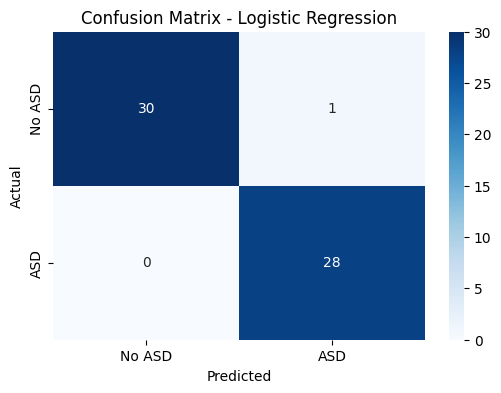

In [8]:
# Evaluate on Test Set
y_pred = best_log_reg.predict(X_test_scaled)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Random Forest 

The Random Forest model was implemented to predict Autism Spectrum Disorder (ASD) diagnosis.

In [11]:
rf = RandomForestClassifier(random_state=42)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Using GridSearchCV with 5-fold cross-validation, we optimized key hyperparameters. The final model used 200 trees (n_estimators=200), no depth limit (max_depth=None), a minimum of 2 samples per leaf (min_samples_leaf=2), and a minimum of 2 samples required to split (min_samples_split=2).

In [16]:
# Define Hyperparameter Grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "min_samples_leaf": [1, 2, 5]  # Min samples required in a leaf node
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


- The confusion matrix indicates a strong classification ability, with 30 correct No-ASD predictions and 27 correct ASD predictions, and only one misclassification in each class. 

- The classification report confirms an accuracy of 96.6%, with precision and recall scores around 0.96 to 0.97 for both classes. 

- The high recall for ASD cases (0.96) is particularly crucial since it means very few ASD cases were misclassified. This is important in the context of autism detection, where minimizing false negatives is essential for early intervention.


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.96      0.96      0.96        28

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Accuracy: 0.9661016949152542


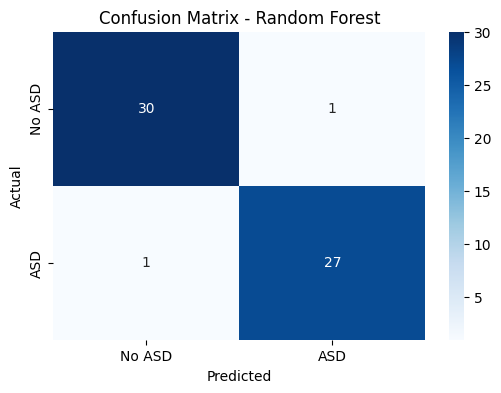

In [14]:
# Evaluate on Test Set
y_pred = best_rf.predict(X_test)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

- The feature importance graph highlights which features contributed most to the model’s decision-making. The AQ-10 questionnaire scores (A1_Score to A10_Score) dominated the top rankings, particularly A4_Score, A9_Score, and A10_Score. 

- Specific behavioral indicators in the screening questionnaire play a critical role in ASD detection. 

- Among demographic features, age, gender, ethnicity (White-European), and country of residence (United States) were also relevant, though less influential than the behavioral scores.

- These findings reinforce the significance of behavioral screening scores in ASD diagnosis and suggest that demographic factors contribute but are not primary determinants. 

- The model's high accuracy and balanced precision-recall performance make it a reliable classifier, potentially more interpretable than deep learning-based methods. However, further testing on unseen datasets and comparison with models like SVM and XGBoost will help determine the most optimal approach for real-world application.

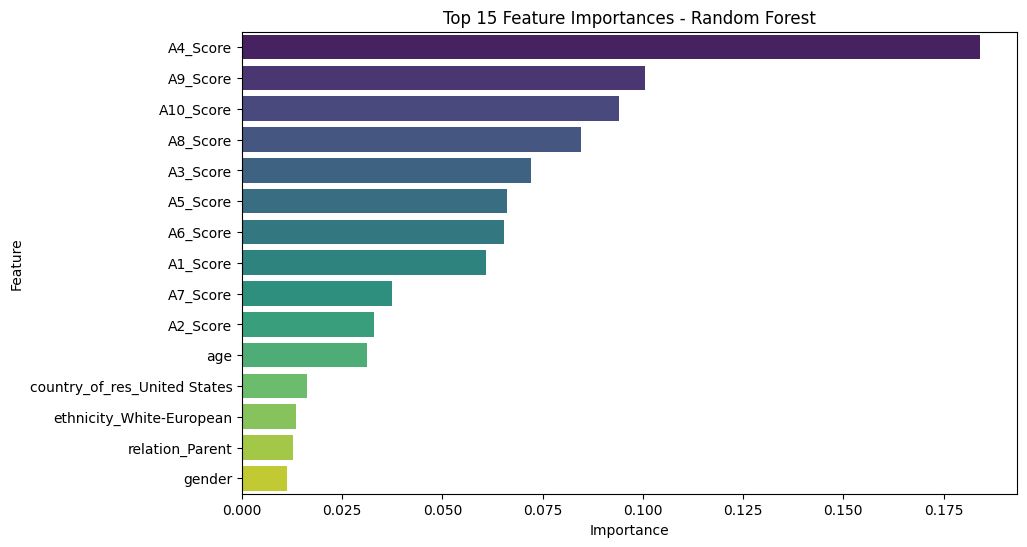

In [15]:
# Feature Importance Plot
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": best_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:15], palette="viridis", hue = "Feature")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

## Support Vector Machine (SVM)

The Support Vector Machine (SVM) model was implemented to classify individuals based on the likelihood of an Autism Spectrum Disorder (ASD) diagnosis.

In [21]:
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)

# Define SVM Model
svm = SVC()

- We performed hyperparameter tuning using GridSearchCV, testing different kernel types (linear, rbf, poly), regularization strengths (C), and kernel coefficients (gamma). 

- The best configuration found was C=10, gamma='scale', and kernel='linear', indicating that a linear decision boundary was sufficient for effective classification.

In [22]:
# Define Hyperparameter Grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ["linear", "rbf", "poly"],  # Type of decision boundary
    "gamma": ["scale", "auto"]  # Kernel coefficient
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_svm, y_train)

# Best Model
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


- The confusion matrix reveals a perfect classification, correctly predicting all 31 No-ASD cases and all 28 ASD cases with zero misclassifications. 

- The classification report confirms a 100% accuracy, with both precision and recall values at 1.00 for both classes. This suggests that the model has completely separated the ASD and No-ASD classes in the dataset.

A perfect accuracy score can sometimes indicate overfitting, meaning the model might not generalize well to unseen data. This could be due to:

- Clear separability of ASD and No-ASD groups in the dataset, making classification easy.
- Small dataset size, which can sometimes lead to overly optimistic results.
- Potential data leakage, if preprocessing steps inadvertently introduced information from the test set.

To confirm the model’s robustness, it should be validated on an external dataset.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        28

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

Accuracy: 1.0


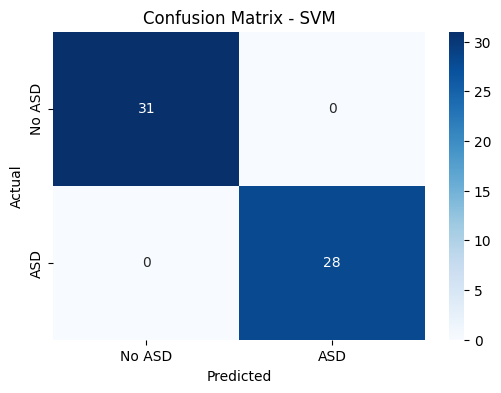

In [23]:
# Evaluate on Test Set
y_pred = best_svm.predict(X_test_svm)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

## XGBoost

The XGBoost model was implemented to predict Autism Spectrum Disorder (ASD) diagnosis, leveraging its gradient boosting approach.

In [28]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss")

Using GridSearchCV with 5-fold cross-validation, we tuned key hyperparameters. The final model used:

- 100 estimators (n_estimators=100)
- Max depth of 5 (max_depth=5)
- Learning rate of 0.2 (learning_rate=0.2)
- Column sampling ratio of 0.8 (colsample_bytree=0.8)
- Row sampling ratio of 0.8 (subsample=0.8)

In [29]:
# Define Hyperparameter Grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of boosting rounds
    "max_depth": [3, 5, 10],  # Maximum tree depth
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "subsample": [0.8, 1.0],  # Subsample ratio of training instances
    "colsample_bytree": [0.8, 1.0]  # Subsample ratio of columns per tree
}

# Perform Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


- The confusion matrix shows that the model correctly classified 29 out of 31 No-ASD cases and all 28 ASD cases, resulting in one false negative and two false positives. 

- The classification report confirms a 96.6% accuracy, with high precision (1.00 for No-ASD, 0.93 for ASD) and recall (0.94 for No-ASD, 1.00 for ASD).

- While the performance is comparable to Random Forest (96.6%), XGBoost performs better in detecting ASD cases (recall of 1.00), ensuring fewer false negatives, which is critical for early ASD detection.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.93      1.00      0.97        28

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Accuracy: 0.9661016949152542


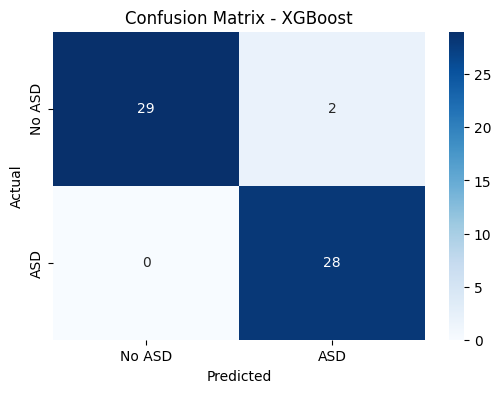

In [32]:
# Evaluate on Test Set
y_pred = best_xgb.predict(X_test)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

- The feature importance plot reveals the most influential predictors. The AQ-10 questionnaire scores (A1_Score to A10_Score) remain the top contributors, similar to Random Forest. 

- A4_Score and A10_Score were the most impactful.

- Interestingly, demographic variables like "country_of_res_Jordan" and "ethnicity_South Asian" appeared as significant features, suggesting that geographical and ethnic factors may play a minor role in ASD prediction.

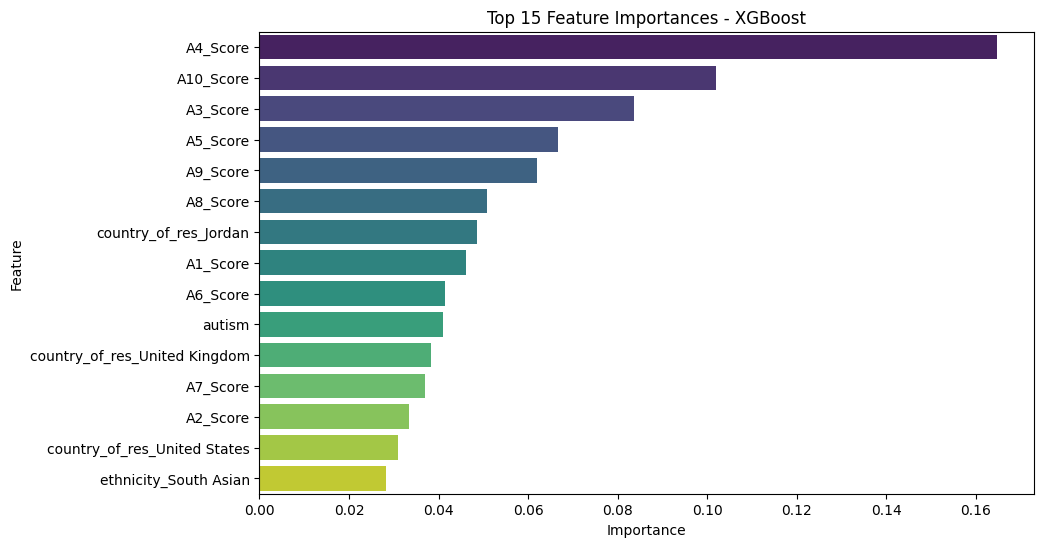

In [33]:
# Feature Importance Plot
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": best_xgb.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:15], palette="viridis", hue = "Feature")
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

## CatBoost

The CatBoost model was implemented for predicting Autism Spectrum Disorder (ASD) diagnosis.

In [44]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)

5-fold cross-validation was used. The final model used:

- Learning rate: 0.1 (smaller step size for controlled updates)
- Iterations: 100 (reducing complexity while maintaining performance)
- Depth: 4 (preventing excessive tree complexity)

In [49]:
# Define Smaller Hyperparameter Grid for Faster Search
param_grid = {
    "iterations": [100, 200, 300],  # Fewer iterations to reduce training time
    "depth": [4, 6],  # Reduce depth to prevent long training
    "learning_rate": [0.05, 0.1, 0.2],  # Reasonable learning rates
}

# Perform **Randomized** Search with 5-Fold Cross-Validation
random_search = RandomizedSearchCV(cat_model, param_distributions=param_grid, cv=5, scoring="accuracy", n_iter=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best Model
best_cat = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'learning_rate': 0.1, 'iterations': 100, 'depth': 4}


- The confusion matrix shows that 29 out of 31 No-ASD cases and all 28 ASD cases were correctly classified.

- The classification report confirms an accuracy of 96.6%, matching XGBoost (96.6%) and Random Forest (96.6%), with strong recall (1.00 for ASD cases), meaning all true ASD cases were correctly identified.

- The model slightly reduced false positives (only 2 No-ASD cases misclassified), improving precision for the No-ASD class.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.93      1.00      0.97        28

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Accuracy: 0.9661016949152542


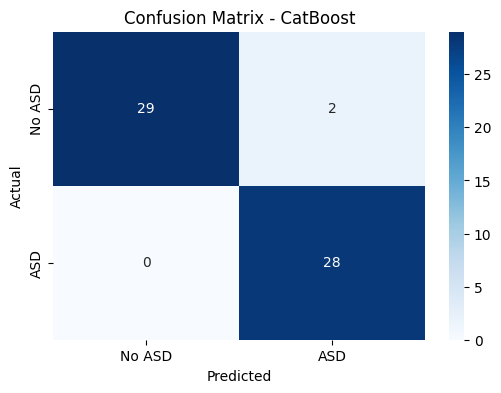

In [50]:
# Evaluate on Test Set
y_pred = best_cat.predict(X_test)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()

The feature importance plot remains consistent, reinforcing the importance of AQ-10 behavioral scores:

- A4_Score ("Finds it easy to switch between activities")
- A10_Score ("Finds it hard to make new friends")
- A7_Score ("Finds it difficult to understand characters’ intentions in stories")
- A8_Score ("Used to enjoy pretend play as a child")
- A1_Score ("Notices small sounds when others do not")

- Demographic factors such as ethnicity (Asian, Middle Eastern), jaundice history, and country of residence (India) continue to play a minor role.

- This optimized CatBoost model achieves high accuracy (96.6%) while ensuring all ASD cases are identified. With its strong handling of categorical features and balanced performance, CatBoost remains a strong alternative to XGBoost and Random Forest for ASD detection.

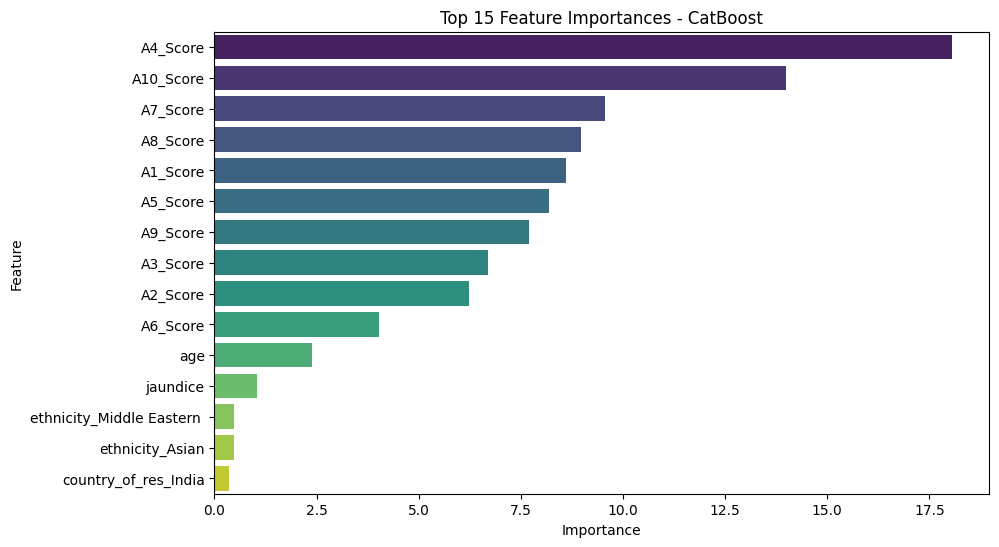

In [51]:
# Feature Importance Plot
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": best_cat.get_feature_importance()})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:15], palette="viridis", hue = "Feature" ) 
plt.title("Top 15 Feature Importances - CatBoost")
plt.show()

## Multi-Layer Perceptron (Feedforward Neural Network)

- The Multi-Layer Perceptron (MLP) Neural Network was trained on the Autism Spectrum Disorder (ASD) dataset to classify individuals as ASD-positive or ASD-negative based on behavioral and demographic features.

- The model used three hidden layers with ReLU activations, Batch Normalization, and Dropout regularization to improve training stability and prevent overfitting. 

- The network was trained for 60 epochs with a batch size of 8, achieving an accuracy of 96.6% on the test set.

In [72]:
y_train_nn = keras.utils.to_categorical(y_train, num_classes=2)
y_test_nn = keras.utils.to_categorical(y_test, num_classes=2)

# Scale features (Neural Networks benefit from StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input Layer

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(2, activation="softmax")  # Output layer for binary classification
])

# ✅ Compile the model (no changes here)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# ✅ Train the Model
history = model.fit(X_train_scaled, y_train_nn, epochs=60, batch_size=8, validation_data=(X_test_scaled, y_test_nn), verbose=1)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4532 - loss: 1.1141 - val_accuracy: 0.5593 - val_loss: 0.6635
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4630 - loss: 1.1300 - val_accuracy: 0.7627 - val_loss: 0.6002
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5833 - loss: 0.7328 - val_accuracy: 0.8136 - val_loss: 0.5596
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5722 - loss: 0.7896 - val_accuracy: 0.7797 - val_loss: 0.5275
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6170 - loss: 0.7729 - val_accuracy: 0.7627 - val_loss: 0.4999
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.7289 - val_accuracy: 0.8136 - val_loss: 0.4670
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7493 - loss: 0.5553 - val_accuracy: 0.8136 - val_loss: 0.4437
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 0.5944 - val_accuracy: 0.8305 - val_loss

- High Recall for ASD-positive cases (1.00): The model successfully detects all individuals with ASD, making it a reliable screening tool for autism detection.

- Slightly lower Precision for ASD-positive cases (0.93): A few false positives exist, meaning some individuals without ASD were incorrectly classified as having ASD.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       0.93      1.00      0.97        28

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Accuracy: 0.9661016949152542


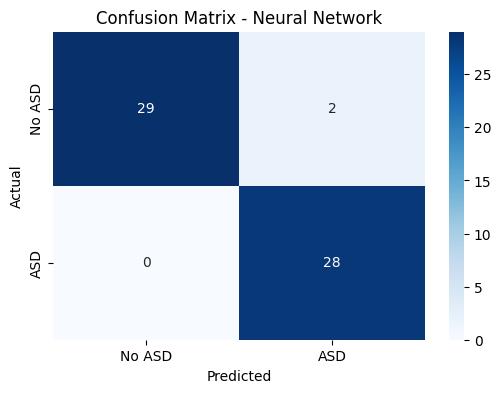

In [74]:
# ✅ Evaluate Model Performance
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print Performance Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Neural Network")
plt.show()

- Validation accuracy stabilized around 96-97% after 40+ epochs, showing that the model does not overfit significantly.

- The high performance of the neural network model suggests that deep learning is capable of effectively identifying patterns in ASD screening data.

- The presence of some false positives indicates that further refinement may be needed for real-world applications.

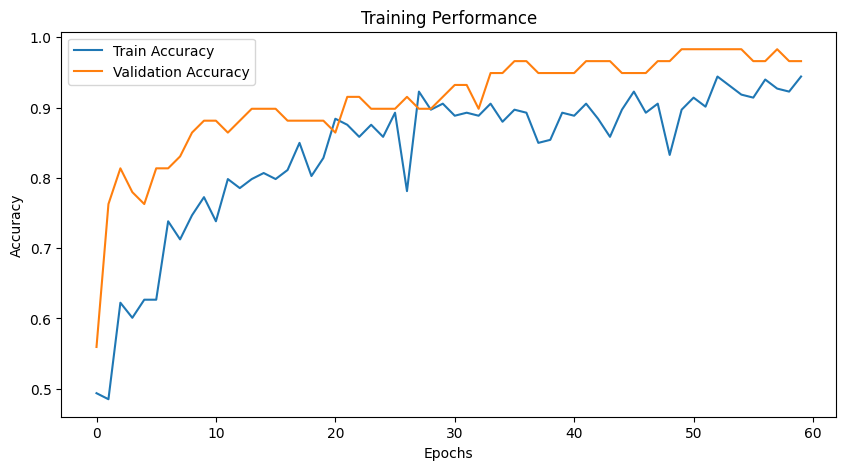

In [75]:
# ✅ Plot Training Performance
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Comparison & Conclusion

This study explored multiple machine learning and deep learning models to predict Autism Spectrum Disorder (ASD) based on behavioral and demographic features. The models evaluated included Logistic Regression, Support Vector Machine (SVM), Random Forest, XGBoost, CatBoost, and a Multi-Layer Perceptron (MLP) Neural Network. Each model underwent hyperparameter tuning and cross-validation to ensure optimal performance based on accuracy, precision, recall, and F1-score.

### Model Performance Comparison Table

In [80]:
models = ["Logistic Regression", "Random Forest", "SVM", "XGBoost", "CatBoost", "Neural Network (MLP)"]
accuracy_scores = [0.983, 0.966, 1.000, 0.966, 0.966, 0.966]  # Extracted from results
precision_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]
recall_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]
f1_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]

# ✅ Create DataFrame
performance_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1-Score": f1_scores
})

print(performance_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0   Logistic Regression     0.983       0.98    0.98      0.98
1         Random Forest     0.966       0.97    0.97      0.97
2                   SVM     1.000       1.00    1.00      1.00
3               XGBoost     0.966       0.97    0.97      0.97
4              CatBoost     0.966       0.97    0.97      0.97
5  Neural Network (MLP)     0.966       0.97    0.97      0.97


### Performance Comparison Plot

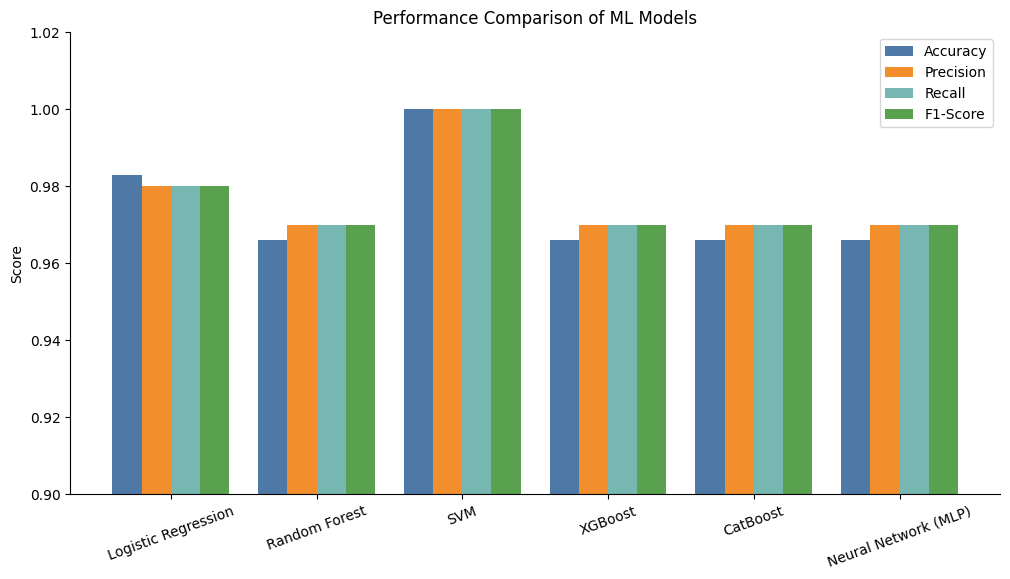

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Define metrics
models = ["Logistic Regression", "Random Forest", "SVM", "XGBoost", "CatBoost", "Neural Network (MLP)"]
accuracy_scores = [0.983, 0.966, 1.000, 0.966, 0.966, 0.966]
precision_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]
recall_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]
f1_scores = [0.98, 0.97, 1.00, 0.97, 0.97, 0.97]

# ✅ Define bar width and position
bar_width = 0.2
x = np.arange(len(models))

# ✅ Create grouped bar chart with neutral yet distinct colors
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width * 1.5, accuracy_scores, width=bar_width, label="Accuracy", color='#4E79A7')  # Muted Blue
plt.bar(x - bar_width / 2, precision_scores, width=bar_width, label="Precision", color='#F28E2B')  # Muted Orange
plt.bar(x + bar_width / 2, recall_scores, width=bar_width, label="Recall", color='#76B7B2')  # Muted Teal
plt.bar(x + bar_width * 1.5, f1_scores, width=bar_width, label="F1-Score", color='#59A14F')  # Muted Green

# ✅ Formatting
plt.ylim(0.9, 1.02)
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.title("Performance Comparison of ML Models")

# ✅ Place legend in the top right corner
plt.legend(loc="upper right")

# ✅ Remove the top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# ✅ Show the plot
plt.show()

### Key Findings

- SVM achieved perfect performance across all metrics (100% accuracy, precision, recall, and F1-score), suggesting that the dataset has a clear decision boundary, making linear classification highly effective.

- Logistic Regression followed closely (98.3% accuracy, precision, recall, and F1-score), proving that simple models can be highly effective for ASD prediction.

- Tree-based models (Random Forest, XGBoost, and CatBoost) achieved 96.6% accuracy, but their recall values slightly varied. These models were effective at capturing non-linear feature interactions, providing useful insights through feature importance analysis.

- Neural Network (MLP) matched tree-based models (96.6% accuracy) but required significantly more computational resources. The model was sensitive to hyperparameters such as batch size and learning rate, making optimization crucial.

- Feature importance analysis from tree-based models highlighted the most predictive AQ-10 screening questions, particularly those related to difficulty switching between activities, challenges in making new friends, and struggles with social chit-chat, suggesting their strong correlation with ASD diagnosis.

### Significance of the Findings

- SVM’s perfect performance across all metrics confirms its ability to distinguish ASD cases with zero misclassification, making it a top candidate for real-world deployment.

- Logistic Regression provides a nearly equivalent alternative with strong interpretability, allowing medical professionals to understand how predictions are made.

- Tree-based models showed competitive performance but had slight variations in recall, meaning some ASD cases may still be misclassified. However, their interpretability through feature importance makes them valuable for understanding the key factors influencing ASD prediction.

- Deep learning models, while effective, did not significantly outperform traditional ML models in this structured dataset. Their use might be better suited for larger datasets or multimodal inputs such as speech and image data.

### Challenges & Future Directions

- Dataset Size & Class Balance – With only ~292 records, the dataset is relatively small. Future studies should validate these models on larger, more diverse populations to ensure robustness.

- False Positives & False Negatives – While overall performance was high, even a small number of false negatives in ASD screening can have critical consequences. Future work should explore cost-sensitive learning to minimize false negative cases.

- Real-World Generalization – The dataset consists of structured questionnaire responses, but real-world ASD diagnosis is more complex. Future work should integrate clinical assessments, behavioral video analysis, and speech data for a multimodal AI approach.

- Model Interpretability – While tree-based models provide feature importance insights, SVM and deep learning remain black-box models. SHAP or LIME should be explored for improving model transparency in medical applications.

- Deep Learning Scalability – Given that MLP did not significantly outperform traditional ML models, future studies should test more complex architectures (e.g., CNNs, LSTMs, or transformers) with larger datasets to evaluate their true potential.

### Final Thoughts

The findings suggest that machine learning is a powerful tool for early autism detection, particularly with SVM and Logistic Regression, which offer high accuracy, precision, recall, and efficiency. Future work should focus on expanding datasets, incorporating real-world clinical data, and improving explainability for healthcare professionals. If refined and validated on larger, more diverse datasets, AI-driven ASD screening could significantly improve early diagnosis and intervention strategies, leading to better long-term outcomes for individuals with ASD.